<a href="https://colab.research.google.com/github/haosulab/SAPIEN-tutorial/blob/master/basics/3_physics.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Note: Some core features of SAPIEN are not available on Colab, including the interactive viewer and ray-tracing functionalities. You need to run SAPIEN locally for full features. You can also find the latest SAPIEN tutorial at [SAPIEN's documentation](https://sapien.ucsd.edu/docs/latest/index.html).

# Basics Tutorial 3: Physics

Since SAPIEN is a physical simulation framework, we would like to showcase how to change physical properties which lead to different behaviors.

In this tutorial, you will learn the following:

- Use `SceneConfig` to initialize default physical properties
- Use `PhysicalMaterial` to set different physical materials
- Create kinematic actors
- Enable damping for actors
- Get kinematic quantities (pose, velocity, angular velocity) of an actor

## Preparation

> Note: you need GPU runtime to run the notebook.

In [2]:
%pip install sapien matplotlib

import sapien.core as sapien
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from  transforms3d.quaternions import axangle2quat

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

%matplotlib inline

The example illustrates an object sliding down the slope. You can run the script with different arguments.

In [5]:
# 修正后的 Set default physical properties 部分
scene = sapien.Scene() # SAPIEN 3.0 推荐直接创建 Scene
scene.set_timestep(1 / 100.0)

# 设置重力
scene.set_ambient_light([0.5, 0.5, 0.5]) # 顺便初始化灯光
# 注意：重力现在通常在创建场景后通过 PhysX 接口或直接设置
# 在 3.0 中，你可以这样设置重力：
scene.physx_system.config.gravity = np.array([0, 0, gravity])

# Set physical materials 部分
physical_material = scene.create_physical_material(
    static_friction=static_friction,
    dynamic_friction=dynamic_friction,
    restitution=restitution,
)

## Set default physical properties

Default physical properties can be specified when a scene is created. Those properties include gravity, static and dynamic friction, as well as [restitution](https://en.wikipedia.org/wiki/Coefficient_of_restitution) (elasticity of collision).

In [7]:
import sapien

# 1. 在 SAPIEN 3.0 中直接创建 Scene，不再需要手动创建 Engine 和 Renderer
scene = sapien.Scene()

# 2. 设置时间步长
scene.set_timestep(1 / 100.0)

# 3. 设置重力 (通过 physx_system 配置)
# 这里的 gravity 变量应为你之前在超参数中定义的 -9.8
scene.physx_system.config.gravity = [0, 0, gravity]

# 4. 初始化环境光（原 renderer 的部分功能现在直接在 scene 中处理）
scene.set_ambient_light([0.5, 0.5, 0.5])

# 打印确认重力设置
print("Gravity set to:", scene.physx_system.config.gravity)

# 注意：SAPIEN 3.0 删除了 SceneConfig.default_static_friction 等属性。
# 现在的做法是创建一个 PhysicalMaterial，然后在创建物体（Actor）时传进去。
physical_material = scene.create_physical_material(
    static_friction=static_friction,
    dynamic_friction=dynamic_friction,
    restitution=restitution,
)

Gravity set to: [ 0.   0.  -9.8]


`SceneConfig` describes default physical properties, and can be passed to `Scene`.

## Set physical materials

`PhysicalMaterial` describes physical (contact) properties (friction and restitution) of the material of an actor. It can be specified when an actor is created. If not provided, the default physical material, induced by the scene’s default physical properties, will be used. Note that `PhysicalMaterial` can only be created by `create_physical_material(...)`.

In [11]:
physical_material = scene.create_physical_material(
    static_friction=static_friction,
    dynamic_friction=dynamic_friction,
    restitution=restitution,
)

Some other physical properties, like density, are directly provided to collision shapes.

In [19]:
def create_sphere(
        scene: sapien.Scene,
        pose: sapien.Pose,
        radius,
        color=None,
        density=1000.0,
        physical_material=None,
        name='',
) -> sapien.Entity:
    """Create a sphere."""
    builder = scene.create_actor_builder()
    builder.add_sphere_collision(radius=radius, material=physical_material, density=density)

    # SAPIEN 3.0 修正：使用 RenderMaterial 设置颜色
    material = None
    if color is not None:
        material = sapien.render.RenderMaterial()
        material.set_base_color(np.array(color + [1.0] if len(color) == 3 else color))

    builder.add_sphere_visual(radius=radius, material=material)

    sphere = builder.build(name=name)
    sphere.set_pose(pose)
    return sphere

> Note: The rolling resistance (friction) is not modeled in SAPIEN currently.

## Create a kinematic actor

Now, let’s create a slope. The slope should be a **kinematic** object, rather than a **dynamic** object. In other words, it can not be affected by external forces. We can set `is_kinematic=True` when building the actor.

In [18]:
def create_box(
        scene: sapien.Scene,
        pose: sapien.Pose,
        half_size,
        color=None,
        is_kinematic=False,
        density=1000.0,
        physical_material=None,
        name='',
) -> sapien.Entity:
    """Create a box."""
    half_size = np.array(half_size)
    builder = scene.create_actor_builder()
    builder.add_box_collision(half_size=half_size, material=physical_material, density=density)

    # SAPIEN 3.0 修正：使用 RenderMaterial 设置颜色
    material = None
    if color is not None:
        material = sapien.render.RenderMaterial()
        material.set_base_color(np.array(color + [1.0] if len(color) == 3 else color))

    # 将 material 传给 add_box_visual
    builder.add_box_visual(half_size=half_size, material=material)

    if is_kinematic:
        box = builder.build_kinematic(name=name)
    else:
        box = builder.build(name=name)

    box.set_pose(pose)
    return box

The following provided code will build the rest of the scene.

In [20]:
# 1. 创建地面 (SAPIEN 3.0 适配)
ground = scene.add_ground(altitude=0)

# 将我们之前创建的 physical_material 应用到地面上
for component in ground.get_components():
    if isinstance(component, sapien.physx.PhysxRigidStaticComponent):
        # 修正点：SAPIEN 3.0 使用 get_collision_shapes() 替代 get_shapes()
        for shape in component.get_collision_shapes():
            shape.set_physical_material(physical_material)

# 2. 设置斜面 (Slope) 参数
half_size = [0.25, 0.5, 0.05]
z_offset = offset  # 使用之前定义的 offset 超参数
angle_rad = np.deg2rad(angle)  # 使用之前定义的 angle 超参数

# 计算斜面的位姿
slope_pose = sapien.Pose(
    p=[0, 0, half_size[1] * np.sin(angle_rad) + half_size[2] * np.cos(angle_rad) + z_offset],
    q=axangle2quat([1.0, 0.0, 0.0], angle_rad),
)

# 创建斜面 (Kinematic 表示它固定不动)
slope = create_box(
    scene,
    slope_pose,
    half_size=half_size,
    color=[0.5, 0.5, 0.5],
    name='slope',
    is_kinematic=True,
    physical_material=physical_material
)

# 3. 根据超参数创建物体 (Box 或 Sphere)
if obj == 'box':
    box_half_size = 0.05
    box_pose = sapien.Pose(
        p=[0,
            (half_size[1] - box_half_size) * np.cos(angle_rad) -
            (half_size[2] + box_half_size) * np.sin(angle_rad),
            (half_size[1] - box_half_size) * np.sin(angle_rad) +
            (half_size[2] + box_half_size) * np.cos(angle_rad) + slope_pose.p[2]],
        q=axangle2quat([1.0, 0.0, 0.0], angle_rad),
    )
    actor = create_box(
        scene,
        box_pose,
        half_size=[box_half_size] * 3,
        color=[0., 0., 1.],
        physical_material=physical_material,
        name='box',
    )
elif obj == 'sphere':
    radius = 0.05
    sphere_pose = sapien.Pose(
        p=[0,
            (half_size[1] - radius) * np.cos(angle_rad) -
            (half_size[2] + radius) * np.sin(angle_rad),
            (half_size[1] - radius) * np.sin(angle_rad) +
            (half_size[2] + radius) * np.cos(angle_rad) + slope_pose.p[2]],
    )
    actor = create_sphere(
        scene,
        sphere_pose,
        radius=radius,
        color=[0., 1., 0.],
        physical_material=physical_material,
        name='sphere',
    )
else:
    raise NotImplementedError(f"Unknown object type: {obj}")

print(f"Successfully created {obj} on the slope.")

Successfully created box on the slope.


## Set damping for the actor

Sometimes, you might model some resistance proportional to (linear or angular) velocity, like air resistance. It can be achieved by setting the **damping** of an actor.

In [23]:
# SAPIEN 3.0 适配写法
rigid_component = None

# 1. 遍历实体的所有组件，寻找动态物理组件
for component in actor.get_components():
    if isinstance(component, sapien.physx.PhysxRigidDynamicComponent):
        rigid_component = component
        break

# 2. 如果找到了，则设置阻尼属性
if rigid_component:
    rigid_component.linear_damping = linear_damping
    rigid_component.angular_damping = angular_damping
    print(f"成功设置阻尼: linear={linear_damping}, angular={angular_damping}")
else:
    print("错误：该 actor 没有动态物理组件（PhysxRigidDynamicComponent），无法设置阻尼。")

成功设置阻尼: linear=0.0, angular=0.0


## Get kinematic quantities of an actor

We can acquire kinematic quantities (pose, linear velocity, angular velocity) of an actor through `get_pose()`, `get_velocity()`, `get_angular_velocity()`. Let's see the kinematic properties together with visualization during the object sliding down the slope. If you are running locally, an additional `Viewer` will be opened to display the animation of the motion.

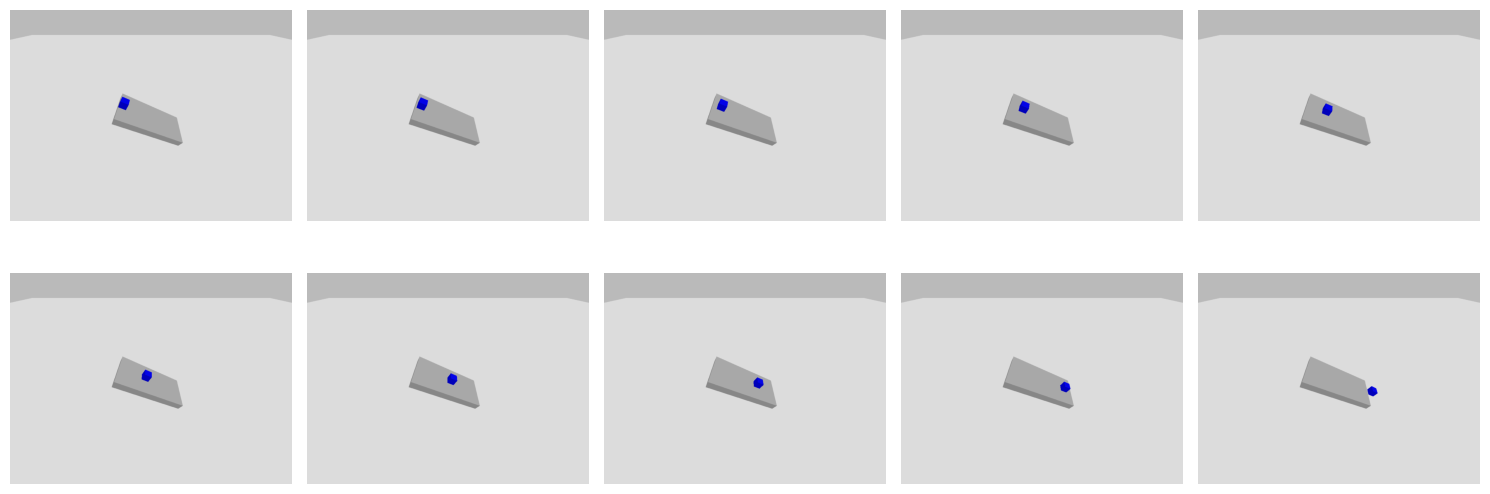


--- Simulation Results ---
Step: 0
  Pose: p=[-1.0887053e-06  3.3909008e-01  7.0454508e-01], q=[ 9.6592599e-01  2.5881884e-01  5.7742823e-06 -2.3058583e-05]
  Linear Velocity: [ 7.4606964e-05 -4.0789608e-02 -2.3659080e-02]
  Angular Velocity: [-0.00064386 -0.00103036  0.00415451]
Step: 10
  Pose: p=[2.1163318e-07 3.2378504e-01 6.9570875e-01], q=[ 9.6592575e-01  2.5881937e-01  3.2421990e-06 -1.3197104e-05]
  Linear Velocity: [ 3.9129285e-05 -2.4486460e-01 -1.4141147e-01]
  Angular Velocity: [-0.00113985 -0.00120343  0.00283615]
Step: 20
  Pose: p=[1.3803750e-06 2.8807443e-01 6.7509115e-01], q=[ 9.6592528e-01  2.5882119e-01 -7.0703695e-06  2.5725260e-05]
  Linear Velocity: [ 2.9556530e-05 -4.4890606e-01 -2.5930506e-01]
  Angular Velocity: [-0.00533829 -0.00192102  0.00126681]
Step: 30
  Pose: p=[2.7888229e-06 2.3195778e-01 6.4269221e-01], q=[ 9.6592534e-01  2.5882080e-01 -1.5711335e-05  5.9330276e-05]
  Linear Velocity: [ 2.2792874e-05 -6.5297985e-01 -3.7705976e-01]
  Angular Velocity: 

In [25]:
# --- 1. 灯光与相机设置 ---
scene.set_ambient_light([0.5, 0.5, 0.5])
scene.add_directional_light([0, 1, -1], [0.5, 0.5, 0.5])

camera = scene.add_camera(name='camera', width=1024, height=768, fovy=1.57, near=0.1, far=100)
# SAPIEN 3.0 修正：使用 set_entity_pose 消除警告
camera.set_entity_pose(sapien.Pose([-1.04541, 0, 1.54541], [0.92388, 0, 0.382683, 0]))

# --- 2. 准备数据容器 ---
plt.figure(figsize=(15, 6))
step = []
pose = []
velocity = []
angular_velocity = []

# 确保我们能拿到物理组件来读取速度
rigid_component = None
for component in actor.get_components():
    if isinstance(component, sapien.physx.PhysxRigidDynamicComponent):
        rigid_component = component
        break

# --- 3. 仿真循环 ---
if IN_COLAB:
    for steps in range(100):
        scene.step()

        if steps % 10 == 0:
            # 渲染可视化
            scene.update_render()
            camera.take_picture()

            # SAPIEN 3.0 关键修正：使用 get_picture("Color") 获取图片数据
            # 这里的 "Color" 对应原先的 RGBA 数据
            rgba = camera.get_picture("Color")

            plt.subplot(2, 5, steps // 10 + 1)
            plt.imshow(rgba[..., :3]) # 只取 RGB 通道进行显示
            plt.axis('off')

            # 保存运动学数据
            step.append(steps)
            pose.append(actor.get_pose())

            if rigid_component:
                velocity.append(rigid_component.get_linear_velocity())
                angular_velocity.append(rigid_component.get_angular_velocity())
            else:
                velocity.append(np.array([0, 0, 0]))
                angular_velocity.append(np.array([0, 0, 0]))
else:
    # 本地 Viewer 逻辑（适配 SAPIEN 3.0）
    from sapien.utils import Viewer
    viewer = Viewer()
    viewer.set_scene(scene)

    steps = 0
    while not viewer.closed:
        scene.step()
        scene.update_render()
        viewer.render()

        if steps < 100 and steps % 10 == 0:
            camera.take_picture()
            rgba = camera.get_picture("Color")
            plt.subplot(2, 5, steps // 10 + 1)
            plt.imshow(rgba[..., :3])

            step.append(steps)
            pose.append(actor.get_pose())
            if rigid_component:
                velocity.append(rigid_component.get_linear_velocity())
                angular_velocity.append(rigid_component.get_angular_velocity())
        steps += 1

plt.tight_layout()
plt.show()

# --- 4. 打印结果 ---
print("\n--- Simulation Results ---")
for i in range(len(step)):
    print(f"Step: {step[i]}")
    print(f"  Pose: p={pose[i].p}, q={pose[i].q}")
    print(f"  Linear Velocity: {velocity[i]}")
    print(f"  Angular Velocity: {angular_velocity[i]}")

You can adjust the hyperparameters (at the beginning of the notebook) and rerun the notebook to see how changing physical properties will affect the motion of the object.